In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})

# Covariate Shift 0: Introdução

<p><div align="justify">O principal objetivo do aprendizado supervisionado é tentar reconhecer padrões entre variáveis explicativas e uma variável alvo. Matematicamente, no caso da regressão, temos um vetor aleatório $V = (X_1, X_2, \cdots, X_n, Y)$ e supomos que existe uma relação entre as variáveis explicativas $X_i$ e a variável alvo $Y$ do tipo</div></p>

$$
\begin{equation*}
\left(Y \,|\, X_1=x_1, X_2=x_2,\cdots, X_n=x_n\right)\sim f(x_1, x_2,\cdots, x_n) + \varepsilon,
\end{equation*}
$$

<p><div align="justify">onde $f:\mathbb{R}^n\to \mathbb{R}$ é uma função qualquer e $\varepsilon$ é uma variável aleatória com média $0$ chamada de ruído (que possivelmente pode mudar dependendo dos valores de $X_i$ também). O paradigma de aprendizado supervisionado tenta estimar a função $f$ com observações anteriores (uma amostra do vetor aleatório $V$).</div></p>

<p><div align="justify">$\oint$ <em>Ainda que estejamos exemplificando com o problema de regressão por ser mais imediato, o caso de classificação não é muito mais sofisticado. Na classificação binária, estamos interessados em estimar $f:\mathbb{R}^n\to [0,1]$ tal que:</em></div></p>

$$
\begin{equation*}
\left(Y \,|\, X_1=x_1, X_2=x_2,\cdots, X_n=x_n\right)\sim \textrm{Bernoulli}(p)\textrm{, com }p=f(x_1, x_2,\cdots, x_n).
\end{equation*}
$$

<p><div align="justify">Em geral, quando fazemos uma validação cruzada, esperamos que o desempenho da nossa função estimada continue sendo o mesmo que no conjunto de validação quando o modelo se deparar com dados novos. O problema de aprendizado de máquina em ambientes não-estacionários traz novos desafios ao nosso trabalho: e se houver um dataset shift, isto é, e se a distribuição do vetor aleatório $V$ for diferente nos dados que ainda não conhecemos? É razoável esperar que o modelo mantenha o desempenho obtido na validação?</div></p>

<p><div align="justify">Dentro desse contexto há pelo menos duas variações clássicas <a href=#bibliography>[1]</a>. A primeira é o concept shift, que ocorre quando a função $f$ que relaciona as variáveis $X_i$ e $Y$ muda. Um problema aparentemente mais sutil, mas igualmente apavorante é o caso em que a relação entre as variáveis explicativas e a variável alvo é conservada, mas a distribuição das variáveis $X_i$ nos novos exemplos é diferente da distribuição das variáveis $X_i$ nos dados de treinamento. Esse é o covariate shift, situação que vamos aprender a identificar nesta série de posts e dar uma possível abordagem de solução.</div></p>

<p><div align="justify">Antes, vamos construir artificialmente um cenário que apresenta covariate shift para esclarecer as ideias com uma situação prática, e analisar o problema que surge caso isso não seja identificado e tratado adequadamente.</div></p>

___

## Exemplo de dataset shift entre dados de treino e dados de produção

<p><div align="justify">Sejam $X$ uma variável aleatória tal que $X\sim \mathcal{N}(0,1)$, $f:\mathbb{R}\to\mathbb{R}$  uma função da forma $f(x) = \cos(2\pi x)$ e $\varepsilon$ é um ruído modelado como $\varepsilon \sim \mathcal{N}(0,0.25)$. Construiremos um conjunto de dados gerados por esse experimento aleatório.</div></p>

In [2]:
def f(X):
    return np.cos(2 * np.pi * X)

def f_ruido(X, random_state):
    return f(X) + np.random.RandomState(random_state).normal(0, 0.5, size=X.shape[0])

def sample(n, mean=0, random_state=None):
    rs = np.random.RandomState(random_state).randint(
        0, 2**32 - 1, dtype=np.int64, size=2
    )
    X = np.random.RandomState(rs[0]).normal(mean, 1, size=n)
    Y = f_ruido(X, random_state=rs[1])
    return X.reshape(-1, 1), Y.reshape(-1, 1)

<p><div align="justify">Neste exemplo, faremos este experimento $100$ vezes, criando nossos dados com a média de $X$ em $0$ como comentado anteriormente.</div></p>

<p><div align="justify">Apesar do ruído ser da ordem de grandeza $f$, é possível visualizar o padrão da função que guia a geração dos dados. Estamos interessados em fazer previsões: dadas novas observações de $X=x$, queremos estimar os respectivos valores para $(Y \, | \, X=x)$.</div></p>

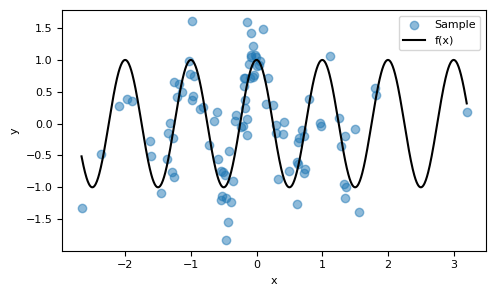

In [3]:
X_past, Y_past = sample(100, random_state=42)

x_plot = np.linspace(np.min(X_past), np.max(X_past), 1000).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(X_past, Y_past, alpha=0.5, label="Sample")
ax.plot(x_plot, f(x_plot), c="k", label="f(x)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.tight_layout()

<p><div align="justify">Usaremos um modelo simples para fazer a regressão, o <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html"><code>sklearn.tree.DecisionTreeRegressor</code></a>. Com um <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html"><code>sklearn.model_selection.GridSearchCV</code></a>, escolhemos o melhor valor para o mínimo de exemplos por folha (parâmetro de regularização, evitando overfit). Com base na validação cruzada, estimamos o valor de <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html"><code>sklearn.metrics.r2_score</code></a> que seria obtido se utilizássemos a árvore em dados nunca antes vistos.</div></p>

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dtr = DecisionTreeRegressor(random_state=42)
param = {"min_samples_leaf": np.arange(1, 10, 1)}
grid_search = GridSearchCV(
    dtr, param, cv=5, scoring="r2", return_train_score=True
).fit(X_past, Y_past)

df_cv = (
    pd.DataFrame(grid_search.cv_results_)
    .sort_values("rank_test_score")
    .filter(["param_min_samples_leaf", "mean_test_score", "std_test_score"])
)
df_cv.head(3)

,param_min_samples_leaf,mean_test_score,std_test_score
2,3,0.554561,0.094576
6,7,0.502175,0.100091
3,4,0.490702,0.131177


<p><div align="justify">Obtemos um $R^2$ razoável, demonstrando que há um aprendizado dos padrões dos dados (apesar de ser um modelo simples e termos poucos exemplos).</div></p>

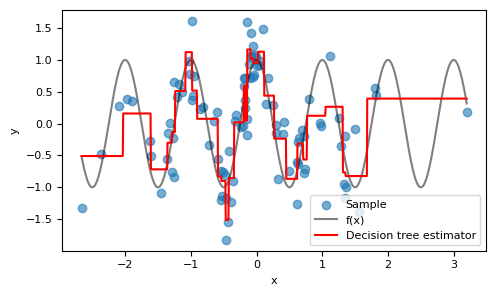

In [5]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(X_past, Y_past, alpha=0.6, label="Sample")
ax.plot(x_plot, f(x_plot), c="k", alpha=0.5, label="f(x)")
ax.plot(
    x_plot,
    grid_search.best_estimator_.predict(x_plot),
    c="r",
    label="Decision tree estimator",
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.tight_layout()

<p><div align="justify">Graficamente, vemos que o modelo faz um bom trabalho ao redor do $x=0$, onde temos uma concentração de valores de $x$, e, naturalmente, perde a qualidade nas bordas, onde há menos exemplos de treinamento.</div></p>

<p><div align="justify">Imaginemos agora que o cenário mudou: apesar da relação entre $X$ e $Y$ continuar sendo a mesma, por algum motivo, a variável $X$ não tem mais distribuição dada por $X\sim \mathcal{N}(0,1)$. Nesta variação, ela é dada por $X\sim \mathcal{N}(2,1)$, ou seja, temos uma translação da distribuição.</div></p>

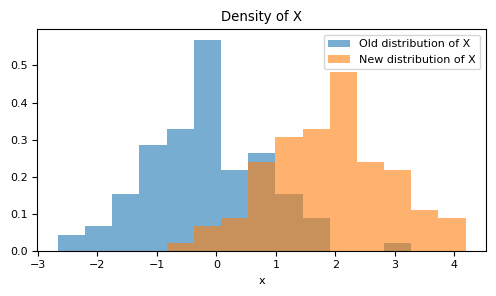

In [6]:
X_new, Y_new = sample(100, mean=2, random_state=13)

min_X = np.min(np.vstack([X_past, X_new]))
max_X = np.max(np.vstack([X_past, X_new]))

fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(
    X_past,
    alpha=0.6,
    bins=np.linspace(min_X, max_X, 16),
    density=True,
    label="Old distribution of X",
)
ax.hist(
    X_new,
    alpha=0.6,
    bins=np.linspace(min_X, max_X, 16),
    density=True,
    label="New distribution of X",
)
ax.set_xlabel("x")
ax.set_title("Density of X")
ax.legend()
plt.tight_layout()

<p><div align="justify">Não é razoável esperar que o nosso modelo continue com a mesma performance que tínhamos anteriorente. A estimação do <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html"><code>sklearn.metrics.r2_score</code></a> estava sendo feita na distribuição antiga de $X$ e agora mudamos ela.</div></p>

<p><div align="justify">$\oint$ <em>Vamos explorar isso com mais detalhe em um post futuro dessa série, mas o modelo anterior estava sendo treinado para achar uma função $h$ tal que</em></div></p>

$$h* = \arg\min_{h\in\mathcal{H}}\,\mathbb{E}_{(X_{\textrm{old}}, Y)} \left(\left(h(X) - Y\right)^2\right),$$

<p><div align="justify"><em>Ou seja, uma hipótese $h$ que minimize a esperança do erro quadrático na distribuição $(X_{\textrm{old}}, Y)$. Isso é feito de forma aproximada, com a amostra observada, calculando o erro quadrático médio empírico. De qualquer forma, agora, estamos olhando para novos dados. O ideal seria minimizar</em></div></p>

$$\mathbb{E}_{(X_{\textrm{new}}, Y)} \left(\left(h(X) - Y\right)^2\right). $$

<p><div align="justify"><em>Ou seja, uma esperança de uma distribuição diferente.</em></div></p>

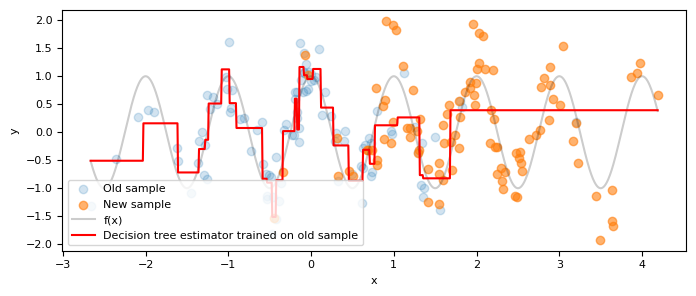

In [7]:
from sklearn.metrics import r2_score

x_plot_new = np.linspace(min_X, max_X, 1000).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(X_past, Y_past, alpha=0.2, label="Old sample")
ax.scatter(X_new, Y_new, alpha=0.6, label="New sample")
ax.plot(x_plot_new, f(x_plot_new), c="k", alpha=0.2, label="f(x)")
ax.plot(
    x_plot_new,
    grid_search.best_estimator_.predict(x_plot_new),
    c="r",
    label="Decision tree estimator trained on old sample",
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(loc="lower left")
plt.tight_layout()

In [8]:
r2_score(Y_new, grid_search.best_estimator_.predict(X_new))

0.059081313039643146

<p><div align="justify">Como esperado, a qualidade do modelo cai nos dados novos. Lembrando que a relação $Y\,|\,X$ não mudou, apenas a distribuição de $X$.</div></p>

___

## Identificando covariate shift

<p><div align="justify">Dada a motivação inicial, temos um desafio resumido no seguinte enunciado:</div></p>

<p><div align="justify">Seja $X$ e $Z$ variáveis (ou vetores) aleatórias. Suponha que amostre $X$ de forma independente $N\in\mathbb{N}^*$ vezes e também $Z$ seja amostrada também de forma independente $M\in \mathbb{N}^*$ vezes ficando com as amostras $\{x_1, x_2, \cdots, x_N \} $ e $\{z_1, z_2, \cdots, z_M \} $. Como saber se $X\sim Z$ olhando apenas para as duas amostras? No contexto específico do covariate shift, vamos estar comparando as amostras das covariáveis no treino e depois em produção.</div></p>

<p><div align="justify">No geral, o monitoramento da distribuição das covariáveis precisa ser simples. Métodos básicos são escolhidos no lugar de técnicas complexas privilegiando eficiência computacional. Além disso, a análise costuma ser feita olhando covariável por covariável, identificando mudanças nessas distribuições marginais. Entre os métodos clássicos univariados, se destacam:</div></p>

- <p><div align="justify">Comparação de estatísticas: médias, variâncias e alguns quantis amostrais;</div></p>

- <p><div align="justify">Comparação de frequências para distribuições discretas e dados categóricos;</div></p>

- <p><div align="justify">Teste de Kolmogorov-Smirnov;</div></p>

- <p><div align="justify">Divergência de Kullback-leibler.</div></p>

<p><div align="justify">Muitas vezes esse monitoramento é feito aliado à análise da distribuição da saída do modelo. Se antes o nosso modelo indicava que 10% dos dados eram de uma classe e agora ele diz que 20% são daquela classe, temos um bom indicativo de que a distribuição de entrada mudou.</div></p>

<p><div align="justify">Nesta série de postagens pretendo apresentar alguns métodos um pouco mais alternativos para identificar o covariate shift. Em seguida, vamos entender porque ele ocorre sob a luz da minimização do risco empírico de Vapnik. Derivaremos uma maneira muito elegante de tratá-lo a partir de uma técnica que será um diagnóstico para identificação do dataset shift.</div></p>

<p><div align="justify">$\oint$ <em>Lembre-se que dataset shift é apenas um dos elementos cruciais quando se trata de monitorar modelos de aprendizado de máquina. Para um guia completo que aborda as principais questões potenciais, sugiro as referências <a href=#bibliography>[2, 3]</a>.</em></div></p>

## <a name="bibliography">Referências</a>

[1] [Dataset Shift in Machine Learning. The MIT Press. Joaquin Quiñonero-Candela, Masashi Sugiyama, Anton Schwaighofer and Neil D. Lawrence](https://mitpress.mit.edu/9780262545877/dataset-shift-in-machine-learning/)

[2] [Monitoring Machine Learning Models in Production. Towards Data Science. Emeli Dral.](https://towardsdatascience.com/monitoring-machine-learning-models-in-production-how-to-track-data-quality-and-integrity-391435c8a299)

[3] [A Guide to Monitoring Machine Learning Models in Production. NVIDIA Developer Blog. Kurtis Pykes.](https://developer.nvidia.com/blog/a-guide-to-monitoring-machine-learning-models-in-production/)